In [1]:
import json
import os
import csv
import rdflib
from rdflib import ConjunctiveGraph, Graph, URIRef, Literal, Namespace
from rdflib.namespace import SKOS, DCTERMS, DCMITYPE, RDF, RDFS, XSD, PROV

from openai import OpenAI
import google.generativeai as genai
from langchain.chains import GraphSparqlQAChain
from langchain_community.graphs import RdfGraph
from langchain_openai import ChatOpenAI

import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
from uk2us import uk_us

import requests
import xml.etree.ElementTree as ET
from html.parser import HTMLParser
from html import unescape
import re
from keybert import KeyBERT

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [2]:
# Opening config file, the config structure is:
# {"access_token_zenodo":"......"
# "openai_api_key":"......"}

config = open('config', 'r')
config = json.load(config)

os.environ['OPENAI_API_KEY'] = config['openai_api_key']
os.environ['GEMINI_API_KEY'] = config['gemini_api_key']

In [96]:
# Load the JSON dataset
with open('benchmarks/text_RDF_gs.json', 'r') as file:
    data = json.load(file)

# Access the dataset
dataset = data['dataset']

In [134]:
with open("in_ontovocabs/classes.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    rows = list(reader)  # Read all rows into a list

    classes = [row['class'] for row in rows]
    clabel = [row['label'] for row in rows]

print(clabel)

['Concept', 'Bibliographic Resource', 'Policy', 'Standard']


In [135]:
with open("in_ontovocabs/properties.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    rows = list(reader)  # Read all rows into a list

    prop = [row['prop'] for row in rows]
    plabel = [row['label'] for row in rows]

print(plabel)

['provides']


In [4]:
def load_graph(data):
    g = rdflib.Graph()
    g.parse(data=data, format="turtle")
    return g

In [5]:
def print_rdf(rdf):
    g = rdflib.Graph()
    g.parse(data=rdf, format="turtle")

    for s, p, o in g:
        print(s, p, o)

In [164]:
# Namespaces
she = Namespace("http://soilwise-he.github.io/soil-health#")
agrovoc = Namespace("http://aims.fao.org/aos/agrovoc/")
agrontology = Namespace("http://aims.fao.org/aos/agrontology#")
glosis_lh = Namespace("http://w3id.org/glosis/model/layerhorizon/")
glosis_sp = Namespace("http://w3id.org/glosis/model/siteplot/")
eli = Namespace("http://data.europa.eu/eli/ontology#")
qudt = Namespace("http://qudt.org/schema/qudt/")
country = Namespace("http://publications.europa.eu/resource/authority/country/")
iso11074 = Namespace("http://data.geoscience.earth/ncl/ISO11074/")

In [7]:
with open('report/soil_report.json', 'r') as file:
    report = json.load(file)

print(report[130]['text'])

Soil nutrient status affects biomass production in natural soils and crop yields in agricultural soils, although the impact is less in fertilised soils. An appropriate nutrient status has positive impacts on biomass production and crop yield. It is defined by appropriate levels of available macronutrients, i.e. nitrogen, phosphorus, calcium, magnesium, potassium and sulphur, and micronutrients, i.e. boron, zinc, manganese, iron, copper and molybdenum. In addition, it affects the diversity of soil microorganisms, soil animals and plant species, which can be positive or negative. In general, a high nitrogen status reduces the diversity but the increase in other nutrients may either increase or decrease diversity. A higher nutrient status further increases carbon storage, especially by the enhanced crop residue input. Finally, a higher nutrient status may reduce water quality, especially in the case of a high phosphorus status, which increases the risk of phosphorus run-off to surface wat

In [8]:
with open('report/references.json', 'r') as file:
    report = json.load(file)

print(report[39]['text'])

Becking, G. C., et al., 2007, 'Essential metals: assessing risks from deficiency and toxicity', in: Nordberg, G. F., et al. (eds), Handbook on the toxicology of metals, 3rd edition, Elsevier, San Diego, pp. 163-176.


### A simple example of converting text to RDF triples

In [99]:
# Corresponding ground-truth RDF statements
print(dataset[0]['rdf_graph_turtle'])

@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

she:Soil a skos:Concept ;
    agrontology:isComposedOf she:Air,
        she:LivingOrganisms,
        she:MineralCompounds,
        she:OrganicCompounds,
        she:Water ;
    agrontology:isPartOf she:TerrestrialLayer ;
    dcterms:source she:YoungCrawford2004 ;
    she:provides she:SoilFunctions ;
    she:variesIn she:Space,
        she:Time ;
    skos:broader she:Biomaterials ;
    skos:definition "The top terrestrial layer of the Earth."@en ;
    skos:prefLabel "soil"@en ;
    skos:related she:EcosystemServices .

she:SoilVariability a skos:Concept ;
    skos:definition "Soil varies naturally in both space and time over a range of scales."@en ;
    skos:prefLabel "soil variability"@en .

she:Air a skos:Concept ;
    skos:prefLabel "air"@en .

she:Biomaterials a 

In [11]:
# Raw texts from the report
print(dataset[1]['text'])

In order to manage soil sustainably, and protect it where necessary, knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions. Healthy soils deliver ecosystem services to the best of their capacity. Unquestionable evidence shows that land cultivation and urbanisation have altered many soil properties, causing reduced soil functioning (JRC, 2012; EC, 2020a). Such soils are then degraded, which consequently harms ecosystems and their life support functions. In the case of soil sealing, soil functions are largely and irreversibly lost.


In [57]:
rdf = """@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

she:EcosystemServices a skos:Concept ;
    agrontology:benefitsFrom she:HealthySoils ;
    skos:prefLabel "ecosystem services"@en .

she:Ecosystems a skos:Concept ;
    agrontology:includes she:LifeSupportFunctions ;
    agrontology:isAffectedBy she:DegradedSoils ;
    skos:prefLabel "ecosystems"@en .

she:SoilFunctions a skos:Concept ;
    agrontology:isAffectedBy she:SoilSealing ;
    skos:prefLabel "soil functions"@en .

she:StateOfSoil a skos:Concept ;
    agrontology:isAffectedBy she:ClimaticConditions,
        she:SoilManagement ;
    skos:prefLabel "state of soil"@en .

she:ClimaticConditions a skos:Concept ;
    skos:prefLabel "climatic conditions"@en .

she:HealthySoils a skos:Concept ;
    skos:definition "Healthy soils deliver ecosystem services to the best of their capacity."@en ;
    skos:prefLabel "healthy soils"@en .

she:LandCultivation a skos:Concept ;
    dcterms:source she:EC2020a,
        she:JRC2012 ;
    skos:prefLabel "land cultivation"@en .

she:LifeSupportFunctions a skos:Concept ;
    agrontology:isAffectedBy she:DegradedSoils ;
    skos:prefLabel "life support functions"@en .

she:SoilFunctioning a skos:Concept ;
    agrontology:isAffectedBy she:SoilProperties ;
    dcterms:source she:EC2020a,
        she:JRC2012 ;
    skos:prefLabel "soil functioning"@en .

she:SoilManagement a skos:Concept ;
    skos:prefLabel "soil management"@en .

she:SoilProperties a skos:Concept ;
    agrontology:isAffectedBy she:LandCultivation,
        she:Urbanisation ;
    dcterms:source she:EC2020a,
        she:JRC2012 ;
    skos:prefLabel "soil properties"@en .

she:SoilSealing a skos:Concept ;
    skos:prefLabel "soil sealing"@en .

she:Urbanisation a skos:Concept ;
    dcterms:source she:EC2020a,
        she:JRC2012 ;
    skos:prefLabel "urbanisation"@en .

she:DegradedSoils a skos:Concept ;
    skos:prefLabel "degraded soils"@en ;
    skos:related she:SoilFunctioning .

she:EC2020a a dcterms:BibliographicResource ;
    dcterms:date "2020" .

she:JRC2012 a dcterms:BibliographicResource ;
    dcterms:date "2012" ."""

In [98]:
print(json.dumps(rdf))

"@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .\n@prefix dcterms: <http://purl.org/dc/terms/> .\n@prefix she: <http://soilwise-he.github.io/soil-health#> .\n@prefix skos: <http://www.w3.org/2004/02/skos/core#> .\n\nshe:EcosystemServices a skos:Concept ;\n    agrontology:benefitsFrom she:HealthySoils ;\n    skos:prefLabel \"ecosystem services\"@en .\n\nshe:Ecosystems a skos:Concept ;\n    agrontology:includes she:LifeSupportFunctions ;\n    agrontology:isAffectedBy she:DegradedSoils ;\n    skos:prefLabel \"ecosystems\"@en .\n\nshe:SoilFunctions a skos:Concept ;\n    agrontology:isAffectedBy she:SoilSealing ;\n    skos:prefLabel \"soil functions\"@en .\n\nshe:StateOfSoil a skos:Concept ;\n    agrontology:isAffectedBy she:ClimaticConditions,\n        she:SoilManagement ;\n    skos:prefLabel \"state of soil\"@en .\n\nshe:ClimaticConditions a skos:Concept ;\n    skos:prefLabel \"climatic conditions\"@en .\n\nshe:HealthySoils a skos:Concept ;\n    skos:definition \"Healthy soi

In [52]:
g = load_graph(rdf)

In [59]:
print_rdf(rdf)

http://soilwise-he.github.io/soil-health#SoilFunctions http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#Ecosystems http://aims.fao.org/aos/agrontology#includes http://soilwise-he.github.io/soil-health#LifeSupportFunctions
http://soilwise-he.github.io/soil-health#SoilSealing http://www.w3.org/2004/02/skos/core#prefLabel soil sealing
http://soilwise-he.github.io/soil-health#Urbanisation http://purl.org/dc/terms/source http://soilwise-he.github.io/soil-health#EC2020a
http://soilwise-he.github.io/soil-health#DegradedSoils http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#LandCultivation http://www.w3.org/2004/02/skos/core#prefLabel land cultivation
http://soilwise-he.github.io/soil-health#StateOfSoil http://aims.fao.org/aos/agrontology#isAffectedBy http://soilwise-he.github.io/soil-health#ClimaticConditions
http://soilwise-he


(process:26756): Pango-WARNING **: 13:34:05.481: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:26756): Pango-WARNING **: 13:34:05.498: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:26756): Pango-WARNING **: 13:34:05.515: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



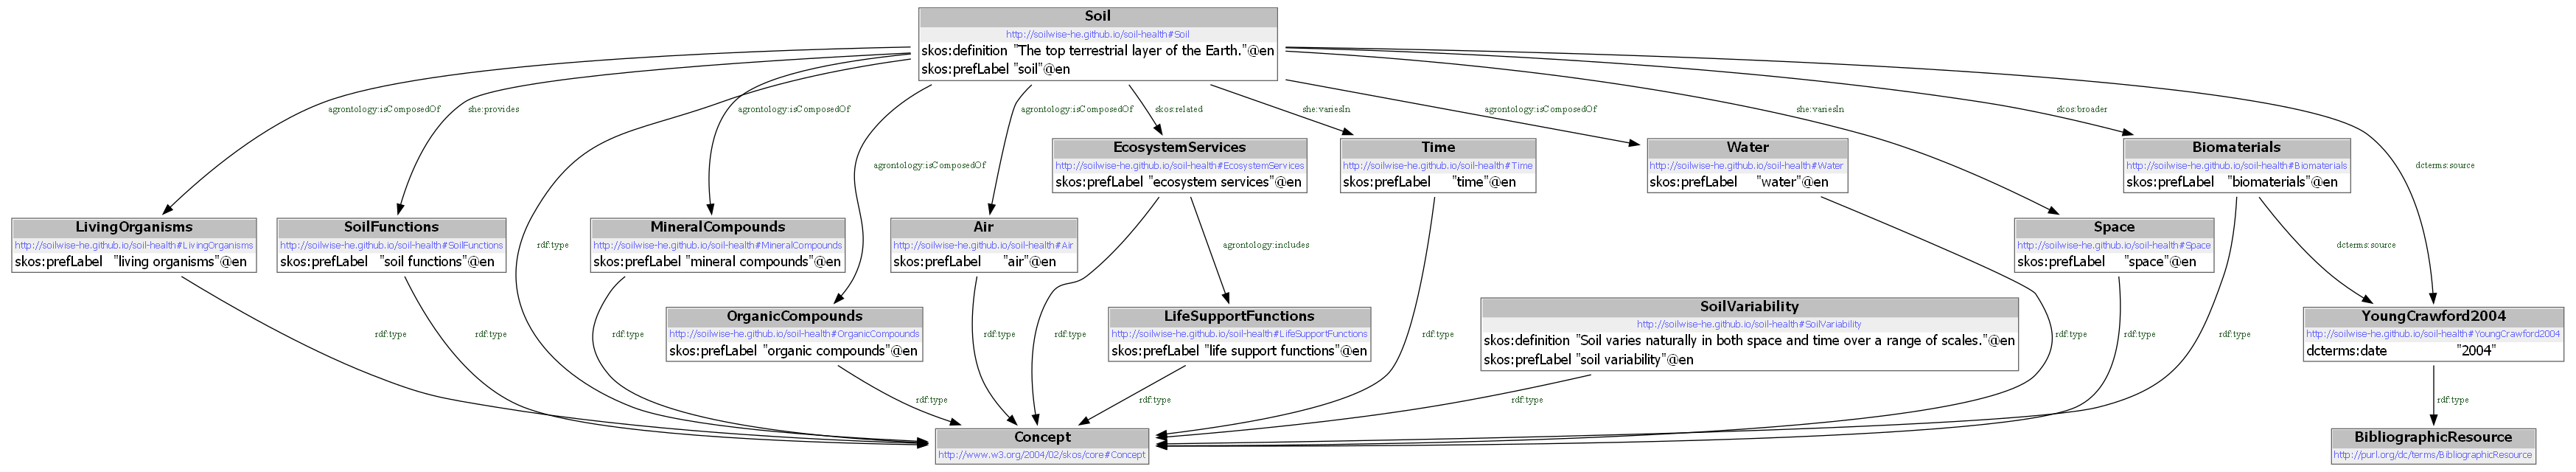

In [19]:
# Visualize the graph
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

visualize(g)

### Convert text to RDF triples using LLMs: zero-shot prompting

In [141]:
# System prompt for zero-shot learning
system_prompt_text = """You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of soil science and soil health. Your task is to identify entities, relationships, references, and objects from a given text, which will be a single paragraph from a soil health report. Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

Subjects represent entities and concepts relevant to soil science and soil health. Attempt to extract as many entities and concepts as you can within this domain. The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

Ensure consistency when labeling subjects. Use available classes for subject labels, focusing on basic or elementary classes. When you identify a subject as a concept, always use 'skos:Concept' to label it. Include a 'skos:prefLabel' with the human-readable name found in the text for every concept and entity. If an entity is not a concept, search for a class from an existing ontology. URIs should be names or human-readable identifiers derived from the text. Use 'she: <http://soilwise-he.github.io/soil-health#>' as prefix. Split words in URIs by capitalizing initial letters.

Relationships represent connections between entities or concepts. Attempt to extract as many relations as you can. Ensure consistency and generality in relationship predicates when constructing knowledge graphs. Instead of using specific and momentary predicates, use more general and timeless relationship predicates. Emphasize generality to enhance the universality and longevity of the knowledge graph.

Maintain entity consistency when extracting entities. If an entity is mentioned multiple times in the text but referred to by different forms, always use the most complete identifier for that entity throughout the knowledge graph.

Do not retain the given text as objects, except in the following case: if the text is defining entities or concepts, include the full definition as an object and use 'skos:definition' as the predicate. Even when you retain parts of the text as objects (definitions), you must still extract entities, relationships, and references according to the previous instructions.

Identify any references or citations that appear in the text. Use Dublin Core ('dcterms') to label references. Represent each reference as a 'dcterms:BibliographicResource'. Use 'dcterms:source' to indicate which information in the text references this literature. When an extracted piece of information is supported by a reference, link it to the corresponding 'dcterms:BibliographicResource' using 'dcterms:source'.

You will receive one paragraph at a time from the soil health report. Focus on extracting information solely from the provided paragraph without assuming context from previous paragraphs. Adhere to the rules strictly. Non-compliance will result in termination."""

print(system_prompt_text)

You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of soil science and soil health. Your task is to identify entities, relationships, references, and objects from a given text, which will be a single paragraph from a soil health report. Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

Subjects represent entities and concepts relevant to soil science and soil health. Attempt to extract as many entities and concepts as you can within this domain. The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

Ensure consistency when labeling subjects. Use available classes for subject labels, focusing on basic or elementary classes. When you identify a subject as a concept, always use 'skos:Concept' to label it. Include a 'skos:prefLabel' with t

In [174]:
prompt_0 = f"""Please help me convert this text to an RDF knowledge graph:
'{dataset[1]['text']}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph serialized in Turtle without any comments. Thank you!"""

In [175]:
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_text},
        {
            "role": "user",
            "content": prompt_0
        }
    ]
)

print(completion.choices[0].message.content)

```turtle
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dcterms: <http://purl.org/dc/terms/> .

she:SustainableSoilManagement a skos:Concept ;
    skos:prefLabel "sustainable soil management" ;
    skos:definition "Knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions." .

she:HealthySoils a skos:Concept ;
    skos:prefLabel "healthy soils" ;
    she:deliver she:EcosystemServices .

she:EcosystemServices a skos:Concept ;
    skos:prefLabel "ecosystem services" .

she:LandCultivation a skos:Concept ;
    skos:prefLabel "land cultivation" ;
    she:alter she:SoilProperties .

she:Urbanisation a skos:Concept ;
    skos:prefLabel "urbanisation" ;
    she:alter she:SoilProperties .

she:SoilProperties a skos:Concept ;
    skos:prefLabel "soil properties" ;
    she:affects she:SoilFunctioning .

she:SoilFunctioning a skos:Concept ;
    skos:prefLab

In [61]:
genai.configure

# Create the model
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 40,
  "response_mime_type": "text/plain",
}

model=genai.GenerativeModel(
  model_name="gemini-1.5-pro",
  generation_config=generation_config,
  system_instruction=system_prompt_text)

response = model.generate_content(prompt_0)
print(response.text)

```turtle
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

she:Soil a skos:Concept ;
    skos:definition "the top terrestrial layer of the Earth" ;
    skos:prefLabel "Soil" .

she:Earth a skos:Concept ;
    skos:prefLabel "Earth" .

she:Soil she:isLocatedIn she:Earth .

she:MineralCompound a skos:Concept ;
    skos:prefLabel "mineral compound" .

she:OrganicCompound a skos:Concept ;
    skos:prefLabel "organic compound" .

she:Water a skos:Concept ;
    skos:prefLabel "water" .

she:Air a skos:Concept ;
    skos:prefLabel "air" .

she:LivingOrganism a skos:Concept ;
    skos:prefLabel "living organism" .

she:Soil she:isComposedOf she:MineralCompound .
she:Soil she:isComposedOf she:OrganicCompound .
she:Soil she:isComposedOf she:Water .
she:Soil she:isComposedOf she:Air .
she:Soil she:isComposedOf she:LivingOrganism .

she:Biomaterial a skos:Concept ;
    skos:prefLabel "bi

In [180]:
rdf_data_llm_0 = completion.choices[0].message.content.replace('```turtle', '')
rdf_data_llm_0 = rdf_data_llm_0.replace('```', '')

print_rdf(rdf_data_llm_0)
g_0 = load_graph(rdf_data_llm_0)

http://soilwise-he.github.io/soil-health#SoilFunctions http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#Ecosystems http://www.w3.org/2004/02/skos/core#prefLabel ecosystems
http://soilwise-he.github.io/soil-health#DegradedSoils http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#SoilSealing http://www.w3.org/2004/02/skos/core#prefLabel soil sealing
http://soilwise-he.github.io/soil-health#EcosystemServices http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#Urbanisation http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#LandCultivation http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-healt

In [155]:
system_prompt_ttl_checker = """You are an **RDF Turtle syntax checker and reviser**. Your task is to:

1. **Receive RDF triples** serialized in Turtle format, which may contain syntax errors or inconsistencies.
2. Be aware that the input may use the custom prefix: `she: <http://soilwise-he.github.io/soil-health#> .`
3. **Analyze the input** and correct any syntactical issues while preserving the original semantic meaning as much as possible.
4. **Output the corrected RDF triples** in Turtle format, ensuring they are syntactically correct and can be directly parsed by the Python library  **"rdflib"** .
5. **Do not include any additional commentary, code block markers, or language identifiers (e.g., ```turtle)** in your output—only the corrected RDF triples."""

In [156]:
prompt_ttl = f"""Please check and correct the following RDF triples:
{completion.choices[0].message.content}"""

In [154]:
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_ttl_checker},
        {
            "role": "user",
            "content": prompt_ttl
        }
    ]
)

print(completion.choices[0].message.content)

@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix dcterms: <http://purl.org/dc/terms/> .

she:Soil a skos:Concept ;
    skos:prefLabel "Soil" ;
    skos:definition "Soil is the top terrestrial layer of the Earth; is composed of a mixture of mineral and organic compounds, water, air and living organisms; is one of the most complex biomaterials on earth (Young and Crawford, 2004); provides multiple functions that support the delivery of ecosystem services, including the life support function; varies naturally in both space and time over a range of scales." ;
    she:isTopLayerOf she:Earth ;
    she:includes she:MixtureOfMineralAndOrganicCompounds, she:Water, she:Air, she:LivingOrganisms ;
    she:supports she:DeliveryOfEcosystemServices ;
    she:variesIn she:Space, she:Time .

she:Earth a skos:Concept ;
    skos:prefLabel "Earth" .

she:MixtureOfMineralAndOrganicCompounds a skos:Concept ;
    skos:prefLabel "Mixture

In [ ]:
# Load the valid agrontology terms from the CSV file
def load_agrontology_terms(csv_file_path):
    agrontology_terms = []
    with open(csv_file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            prop = row['prop'].strip()
            label = row['label'].strip()
            agrontology_terms.append({
                'prop': prop,
                'label': label
            })
    return agrontology_terms

# Preprocess the term to add spaces between camel case words
def preprocess_term(term):
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', term)

# Generate embeddings using OpenAI API
def get_embedding(text):
    preprocessed_text = preprocess_term(text)
    response = client.embeddings.create(
    model="text-embedding-3-large",
    input=preprocessed_text
    )
    return np.array(response.data[0].embedding)

# Precompute embeddings for valid agrontology terms using only label
def embed_valid_terms(valid_terms):
    embeddings = {}
    for term in valid_terms:
        text_to_embed = term['label']
        embeddings[term['prop']] = get_embedding(text_to_embed)
    return embeddings

# Compare custom terms to valid terms using cosine similarity with precomputed embeddings
def find_closest_term(custom_term, valid_terms, valid_embeddings):
    custom_embedding = get_embedding(custom_term)
    valid_term_list = [term['prop'] for term in valid_terms]
    valid_embeddings_list = [valid_embeddings[term] for term in valid_term_list]
    
    similarities = cosine_similarity([custom_embedding], valid_embeddings_list)[0]
    best_match_index = np.argmax(similarities)
    
    return valid_term_list[best_match_index], similarities[best_match_index]

# Main function to check and correct the RDF knowledge graph
def check_and_correct_rdf(rdf_string, csv_file_path):
    # Step 1: Load valid agrontology terms
    agrontology_terms = load_agrontology_terms(csv_file_path)
    valid_props = [term['prop'] for term in agrontology_terms]

    # Step 2: Precompute embeddings for valid agrontology terms
    valid_term_embeddings = embed_valid_terms(agrontology_terms)
    
    # Step 3: Extract predicates from RDF graph
    graph = rdflib.Graph()
    graph.parse(data=rdf_string, format="turtle")
    
    # Step 4: Iterate over all predicates and check if they are valid
    for s, pred, o in graph:
        pred_str = str(pred)
        if pred_str.startswith("http://soilwise-he.github.io/soil-health#"):
            predicate_short = pred_str.split("#")[-1]  # Get the short version of the predicate
            if predicate_short not in valid_props:
                # If the term is not found, find the closest valid term
                closest_term, similarity = find_closest_term(predicate_short, agrontology_terms, valid_term_embeddings)
                print(predicate_short, closest_term, similarity)
                if similarity > 0:  # Threshold for correction
                    # Replace the wrong predicate with the closest valid term
                    new_predicate_uri = f"http://aims.fao.org/aos/agrontology#{closest_term}"
                    graph.add((s, rdflib.URIRef(new_predicate_uri), o))
                    graph.remove((s, pred, o))
                else:
                    graph.remove((s, pred, o))
            else:
                new_predicate_uri = f"http://aims.fao.org/aos/agrontology#{predicate_short}"
                graph.add((s, rdflib.URIRef(new_predicate_uri), o))
                graph.remove((s, pred, o))
    
    graph.bind("agrontology", agrontology)
    # Step 5: Output the corrected RDF triples
    corrected_rdf_turtle = graph.serialize(format="turtle")
    
    return corrected_rdf_turtle

corrected_rdf_turtle = check_and_correct_rdf(g_0.serialize(format="turtle"), 'in_ontovocabs/agrontology.csv')

g_0 = load_graph(corrected_rdf_turtle)
print(g_0.serialize(format="turtle"))

influencedBy influences 0.7666964346510285
hasFormula hasChemicalFormula 0.60280656502064
hasUnits valueUsedIn 0.4345721101169119
influencedBy influences 0.7666733137016887
influencedBy influences 0.7666133609341468
influencedBy influences 0.7666964346510285
@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix math: <http://www.w3.org/2000/10/swap/math#> .
@prefix qudt: <http://qudt.org/schema/qudt#> .
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

she:SocStock a skos:Concept ;
    agrontology:hasChemicalFormula she:CalculationSOCStock ;
    agrontology:influences she:BulkDensity,
        she:CoarseMineralFragmentContent,
        she:LayerThickness,
        she:SocContent ;
    agrontology:valueUsedIn she:TonnesCPerHa ;
    skos:prefLabel "soc stock" .

she:BulkDensity a skos:Concept ;
    qudt:quantityKind qudt:Density ;
    qudt:unit she:KgPerM2 ;
    sk


(process:24800): Pango-WARNING **: 14:25:11.624: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:24800): Pango-WARNING **: 14:25:11.635: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:24800): Pango-WARNING **: 14:25:11.635: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



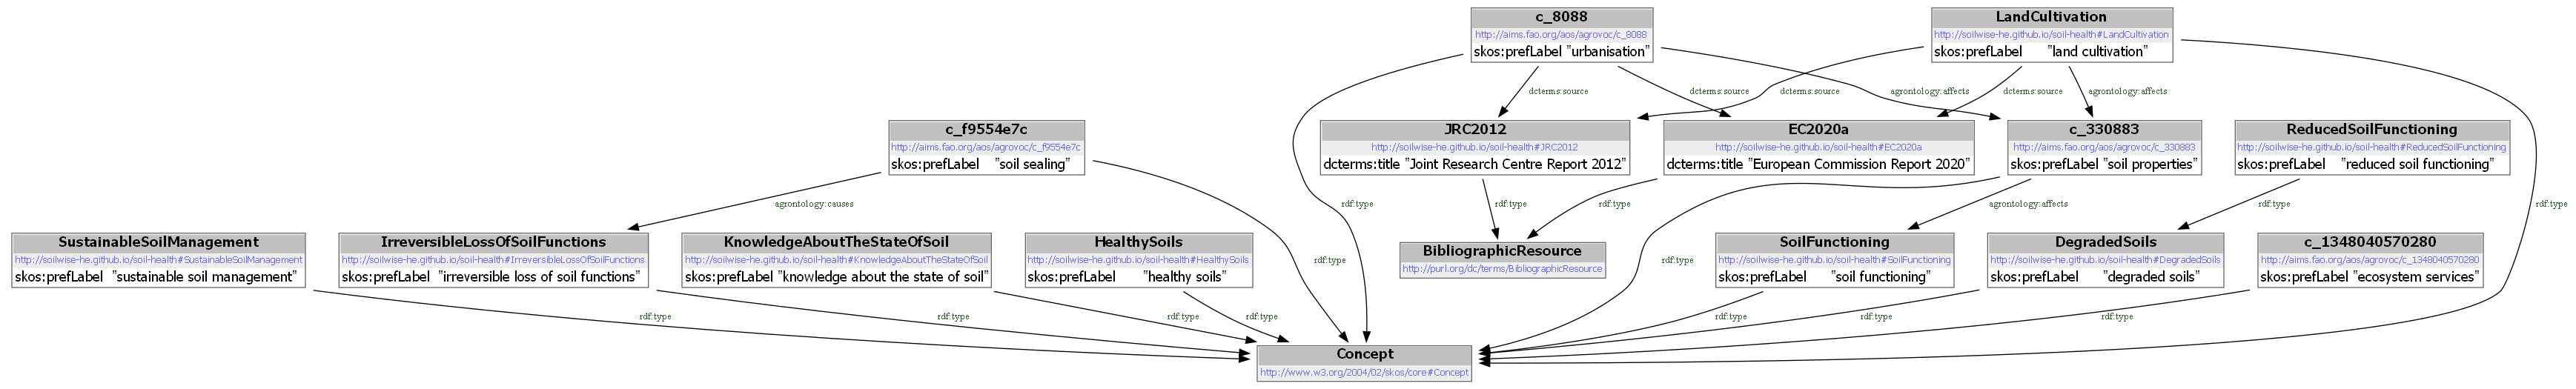

In [31]:
visualize(g_0)

### Prompt engineering

#### Step-by-step prompt

In [74]:
# System prompt for zero-shot learning
system_prompt_step = """# RDF Knowledge Graph Instructions for GPT (Soil Health Domain)
## 1. Overview
You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of **soil science and soil health**.
Your task is to identify entities, relationships, references, and objects from a given text, which will be a **single paragraph from a soil health report**.
Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

## 2. Subjects
- **Subjects** represent entities and concepts relevant to **soil science and soil health**.
- Attempt to extract as many entities and concepts as you can within this domain.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

## 3. Labeling Subjects
- **Consistency**: Ensure you assign at least one available class from existing ontologies and vocabularies to each subject. **Do not customize classes**.
  - When you identify a subject as a concept related to soil science and soil health, always use `'skos:Concept'` to label it.
  - If a subject is not a concept, please search for a class from an extant ontology or vocabulary to label it.
  - For every concept, include a `skos:prefLabel` with the human-readable name in lowercase found in the text.
- **URIs**: URIs should be names or human-readable identifiers derived from the text. Use `she: <http://soilwise-he.github.io/soil-health#>` as prefix. Split words in URIs by capitalizing initial letters.

## 4. Relations and Predicates
- **Relationships** represent connections between entities or concepts.
- Attempt to extract as many relations as you can.
- Ensure consistency and generality in relationship predicates when constructing knowledge graphs.
- Instead of using specific and momentary predicates, use more general and timeless relationship predicates.
- **Emphasize Generality**: Make sure to use general and timeless relationship predicates to enhance the universality and longevity of the knowledge graph.

## 5. Coreference Resolution
- **Maintain Entity/Concept Consistency**: When extracting entities and concepts, it's vital to ensure consistency.
- If an entity or concept is mentioned multiple times in the text but referred to by different forms, always use the most complete identifier and preferred label for that entity or concept throughout the knowledge graph.

## 6. Objects
- **Retaining Text as Objects**: Do not retain the given text as objects. Even when you retain parts of the text as objects, you must still extract entities, relationships, and references according to the previous instructions.

## 7. Quantitative relationship
- Express **quantitative relationships** between entities or concepts, using math ontology, QUDT ontology, or other suitable ontologies.

## 8. References and Citations
- **Extract References**: Identify any references or citations that appear in the text.
- **Labeling References**:
  - Use Dublin Core (`dcterms`) to label references.
  - Represent each reference as a `dcterms:BibliographicResource`.
  - Do not include `skos:prefLabel` for any references, instead use properties from Dublin Core.
- **Connecting Information to References**:
  - Use `dcterms:source` to indicate which information in the text references this literature.
  - When an extracted piece of information is supported by a reference, link it to the corresponding `dcterms:BibliographicResource` using `dcterms:source`.

## 9. Strict Compliance
Adhere to the rules strictly. Non-compliance will result in termination."""

print(system_prompt_step)

# RDF Knowledge Graph Instructions for GPT (Soil Health Domain)
## 1. Overview
You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of **soil science and soil health**.
Your task is to identify entities, relationships, references, and objects from a given text, which will be a **single paragraph from a soil health report**.
Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

## 2. Subjects
- **Subjects** represent entities and concepts relevant to **soil science and soil health**.
- Attempt to extract as many entities and concepts as you can within this domain.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

## 3. Labeling Subjects
- **Consistency**: Ensure you assign at least one available class from existing ontologies and vocab

In [11]:
system_prompt_engi = """# RDF Knowledge Graph Instructions for GPT (Soil Health Domain)
## 1. Overview
You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of **soil science and soil health**.
Your task is to identify entities, relationships, and references from a given text, which will be a **single paragraph from a soil health report**.
Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

## 2. Subjects
- **Subjects** represent entities relevant to **soil science and soil health**.
- Attempt to extract as many entities as you can within this domain.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

## 3. Labeling Subjects
- **Consistency**: Ensure you assign at least one available class from existing ontologies and vocabularies to each subject. **Do not customize classes**.
  - When you identify a subject as a concept related to soil science and soil health, always use `'skos:Concept'` to label it.
  - If a subject is not a concept, please search for a class from an extant ontology or vocabulary to label it.
  - For every concept, include a `skos:prefLabel` with the human-readable name in lowercase found in the text.
- **URIs**: URIs should be names or human-readable identifiers found in the text.
- For example, the concept `'soil health'` should have the URI `'she:SoilHealth'` and include `skos:prefLabel 'soil health'`, where the prefix `she: <http://soilwise-he.github.io/soil-health#>`.

## 4. Relations and Predicates
- **Relationships** represent connections between entities.
- Attempt to extract as many relations as you can.
- Ensure consistency and generality in relationship predicates when constructing knowledge graphs. Instead of using specific and momentary predicates, use more general and timeless relationship predicates. **Make sure to use general and timeless relationship predicates.**
- For example, the relationship extracted from the text `'Soil provides multiple functions'` should be that soil `'isSourceOf'` soil functions, rather than that soil `'provides'` soil functions.

## 5. Coreference Resolution
- **Maintain Entity Consistency**: When extracting entities, it's vital to ensure consistency.
- If an entity, such as `'soil functions'`, is mentioned multiple times in the text but is referred to by different forms (e.g., `'soil function'`, `'functions of soil'`), always use the most complete identifier for that entity throughout the knowledge graph. In this example, use `'soil functions'` as the entity label.
- Remember, the knowledge graph should be coherent and easily understandable, so maintaining consistency in entity references is crucial.

## 6. Objects
- **Retaining Text as Objects**: Do not retain the given text as objects, except in the following case:
  - **Definitions**: If the text is defining concepts, include the full definition as an object and use `'skos:definition'` as the predicate.
- **Important**: Even when you retain parts of the text as objects (definitions), you must still extract entities, relationships, and references according to the previous instructions.

## 7. References and Citations
- **Extract References**: Identify any references or citations that appear in the text.
- **Labeling References**:
  - Use Dublin Core (`dcterms`) to label references.
  - Represent each reference as a `dcterms:BibliographicResource`.
  - For example, a reference like `(Alice and Bob, 2024)` should be represented as: `she:AliceBob2024 a dcterms:BibliographicResource;`. `James et al. (2018)` should be `she:James2018` and `(ABC, 2014a)` should be `she:ABC2014a`.
  - Do not include a `skos:prefLabel` for any reference, use properties from Dublin Core.
- **Connecting Entities to References**:
  - When an extracted entity is supported by a reference, link it to the corresponding `dcterms:BibliographicResource` using `dcterms:source`.

## 8. Strict Compliance
Adhere to the rules strictly. Non-compliance will result in termination."""

print(system_prompt_engi)

# RDF Knowledge Graph Instructions for GPT (Soil Health Domain)
## 1. Overview
You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of **soil science and soil health**.
Your task is to identify entities, relationships, and references from a given text, which will be a **single paragraph from a soil health report**.
Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

## 2. Subjects
- **Subjects** represent entities relevant to **soil science and soil health**.
- Attempt to extract as many entities as you can within this domain.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

## 3. Labeling Subjects
- **Consistency**: Ensure you assign at least one available class from existing ontologies and vocabularies to each subject. **Do not c

In [75]:
prompt_0 = f"""
Please help me convert this text to an RDF knowledge graph:
'{dataset[0]['text']}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph serialized in Turtle without any comments. Thank you!
"""

In [77]:
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_step},
        {
            "role": "user",
            "content": prompt_0
        }
    ]
)

print(completion.choices[0].message.content)

```turtle
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dcterms: <http://purl.org/dc/terms/> .

she:Soil a skos:Concept ;
    skos:prefLabel "soil" ;
    she:topLayer she:Earth ;
    she:composedOf she:MineralCompounds, she:OrganicCompounds, she:Water, she:Air, she:LivingOrganisms ;
    she:complexity she:Biomaterial ;
    she:supports she:EcosystemServices ;
    she:variesNaturallyIn she:Space, she:Time .

she:Earth a skos:Concept ;
    skos:prefLabel "earth" .

she:MineralCompounds a skos:Concept ;
    skos:prefLabel "mineral compounds" .

she:OrganicCompounds a skos:Concept ;
    skos:prefLabel "organic compounds" .

she:Water a skos:Concept ;
    skos:prefLabel "water" .

she:Air a skos:Concept ;
    skos:prefLabel "air" .

she:LivingOrganisms a skos:Concept ;
    skos:prefLabel "living organisms" .

she:Biomaterial a skos:Concept ;
    skos:prefLabel "biomaterial" .

she:EcosystemServices a skos:Concept ;


In [190]:
rdf_data_llm_p = completion.choices[0].message.content.replace('```turtle\n', '')
rdf_data_llm_p = rdf_data_llm_p.replace('\n```', '')

print_rdf(rdf_data_llm_p)
g_p = load_graph(rdf_data_llm_p)

http://soilwise-he.github.io/soil-health#SustainableManagement http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#SoilHealth http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#SubsoilCompaction http://www.w3.org/2004/02/skos/core#prefLabel subsoil compaction
http://soilwise-he.github.io/soil-health#UnsustainableManagement http://www.w3.org/2004/02/skos/core#prefLabel unsustainable land management
http://soilwise-he.github.io/soil-health#UnsustainableManagement http://soilwise-he.github.io/soil-health#causes http://soilwise-he.github.io/soil-health#Degradation
http://soilwise-he.github.io/soil-health#EcosystemServices http://www.w3.org/2004/02/skos/core#prefLabel ecosystem services
http://soilwise-he.github.io/soil-health#SubsoilCompaction http://soilwise-he.github.io/soil-health#isHardTo http://soilwise-he.github.io/soil-hea

In [51]:
corrected_rdf_turtle = check_and_correct_rdf(g_p.serialize(format="turtle"), 'ontovocabs/agrontology.csv')

g_p = load_graph(corrected_rdf_turtle)
print(g_p.serialize(format="turtle"))

0.5833710413608043
0.3889018897233545
0.37490874719340817
0.7299015743889538
0.5834021038606659
0.5833348519700019
0.5833348519700019
0.5833348519700019
0.3889140936788052
0.5833348519700019
@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

agrovoc:c_2482 a skos:Concept ;
    agrontology:isAffectedBy agrovoc:c_7168 ;
    skos:prefLabel "ecosystems" .

agrovoc:c_7156 a skos:Concept ;
    agrontology:isAffectedBy agrovoc:c_8088,
        she:ClimaticConditions,
        she:LandCultivation,
        she:SustainableSoilManagement ;
    agrontology:isSourceOf agrovoc:c_1348040570280 ;
    skos:prefLabel "soil" .

agrovoc:c_e5629cbd a skos:Concept ;
    skos:prefLabel "soil functions" .

agrovoc:c_f9554e7c a skos:Concept ;
    skos:prefLabel "soil sealing" .

she:LifeSu


(process:15540): Pango-WARNING **: 14:51:56.818: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:15540): Pango-WARNING **: 14:51:56.822: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:15540): Pango-WARNING **: 14:51:56.842: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



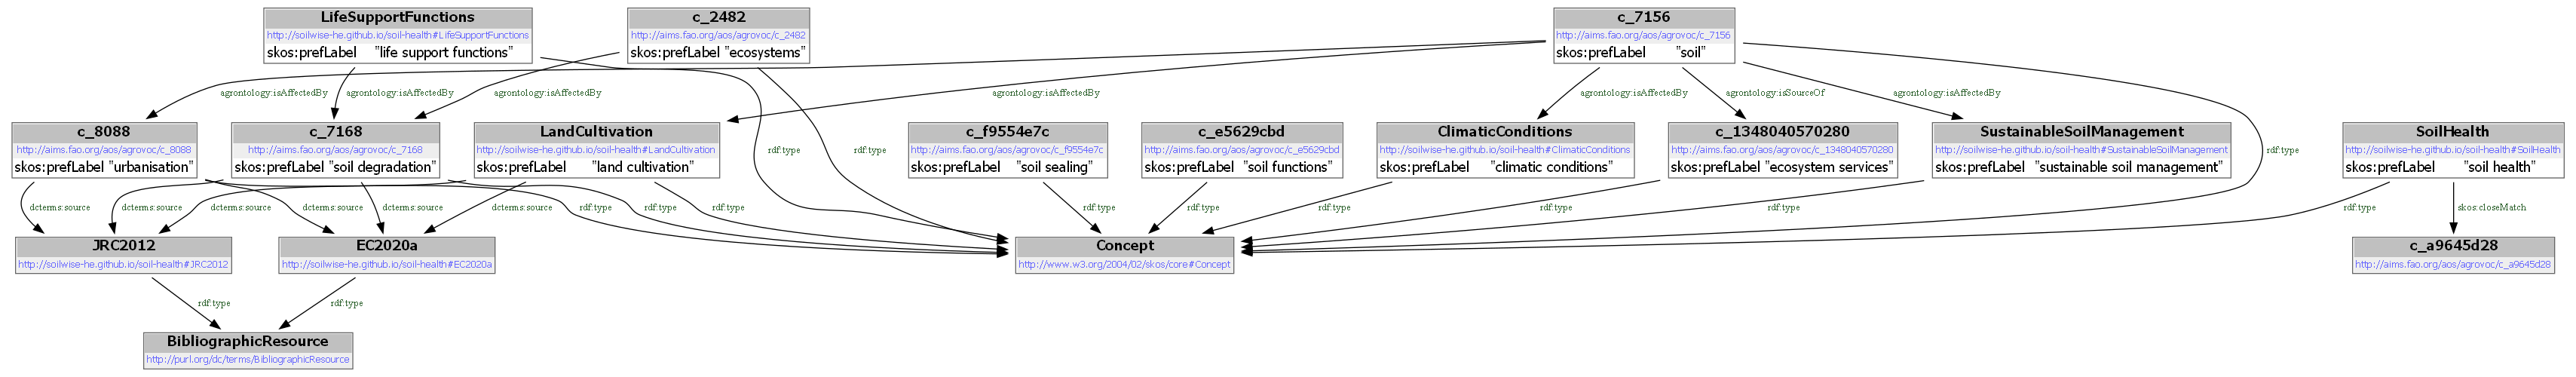

In [52]:
visualize(g_p)

#### Pseudocode prompt

#### Import ontology into prompt

In [131]:
# Load the valid agrontology terms from the CSV file
with open("in_ontovocabs/agrontology.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    label = [row['prop'] for row in reader]

print(label)

['isObjectOfActivity', 'isPropagationProcessOf', 'valueUsedIn', 'hasCodeFaoterm', 'isSourceOf', 'hasChemicalFormula', 'hasCodeTaxonomic', 'isPostProductionPracticeFor', 'hasScientificName', 'usesProcess', 'hasCodeAsc', 'hasType', 'includes', 'prevents', 'hasNaturalEnemy', 'isLocalNameOf', 'isWeedOf', 'makeUseOf', 'hasSynonym', 'hasSymbol', 'isDerivedFrom', 'formerlyIncludes', 'hasPropagationProcess', 'hasSingular', 'hasOldName', 'developsInto', 'formerlyIncludedIn', 'hasBreedingMethod', 'isAGrowthEnvironmentFor', 'isSpatiallyIncludedIn', 'benefitsFrom', 'hasInfectionPart', 'isPartOfSubvocabulary', 'isTransliterationOf', 'affects', 'causativeRelationship', 'study', 'isAbbreviationOf', 'isControlMethodOf', 'greaterThan', 'isOldNameOf', 'isAffectedBy', 'hasGoalOrProcess', 'afflicts', 'scientificNameOf', 'isUseOf', 'isProcessFor', 'isCropingSystemOf', 'pestOf', 'hasProduct', 'isComposedOf', 'includesSubprocess', 'isSubstituteFor', 'hasTermType', 'isPropertyOf', 'isAcronymOf', 'hasTranslite

In [21]:
# System prompt for zero-shot learning
system_prompt_onto = """# RDF Knowledge Graph Instructions for GPT (Soil Health Domain)
## 1. Overview
You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of **soil science and soil health**.
Your task is to identify entities, relationships, references, and objects from a given text, which will be a **single paragraph from a soil health report**.
Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

## 2. Subjects
- **Subjects** represent entities and concepts relevant to **soil science and soil health**.
- Attempt to extract as many entities and concepts as you can within this domain.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

## 3. Labeling Subjects
- **Consistency**: Ensure you assign at least one available class from existing ontologies and vocabularies to each subject. **Do not customize classes**.
  - When you identify a subject as a concept related to soil science and soil health, always use `'skos:Concept'` to label it.
  - If a subject is not a concept, please search for a class from an extant ontology or vocabulary to label it.
  - For every concept, include a `skos:prefLabel` with the human-readable name in lowercase found in the text.
- **URIs**: URIs should be names or human-readable identifiers derived from the text. Use `she: <http://soilwise-he.github.io/soil-health#>` as prefix. Split words in URIs by capitalizing initial letters.

## 4. Relations and Predicates
- **Relationships** represent connections between entities or concepts.
- Attempt to extract as many relations as you can.
- **Use Only Approved Predicates**:
  - Use only the predicates listed in the provided **Predicate List**.
  - Provided predicate list is {label}. The prefix of these predicates is `agrontology: <http://aims.fao.org/aos/agrontology#>`.

## 5. Coreference Resolution
- **Maintain Entity/Concept Consistency**: When extracting entities and concepts, it's vital to ensure consistency.
- If an entity or concept is mentioned multiple times in the text but referred to by different forms, always use the most complete identifier and preferred label for that entity or concept throughout the knowledge graph.

## 6. Objects
- **Retaining Text as Objects**: Do not retain the given text as objects. Even when you retain parts of the text as objects, you must still extract entities, relationships, and references according to the previous instructions.

## 7. References and Citations
- **Extract References**: Identify any references or citations that appear in the text.
- **Labeling References**:
  - Use Dublin Core (`dcterms`) to label references.
  - Represent each reference as a `dcterms:BibliographicResource`.
  - Do not include `skos:prefLabel` for any references, instead use properties from Dublin Core.
- **Connecting Information to References**:
  - Use `dcterms:source` to indicate which information in the text references this literature.
  - When an extracted piece of information is supported by a reference, link it to the corresponding `dcterms:BibliographicResource` using `dcterms:source`.

## 8. Strict Compliance
Adhere to the rules strictly. Non-compliance will result in termination.""".format(label=label)

print(system_prompt_onto)

# RDF Knowledge Graph Instructions for GPT (Soil Health Domain)
## 1. Overview
You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of **soil science and soil health**.
Your task is to identify entities, relationships, references, and objects from a given text, which will be a **single paragraph from a soil health report**.
Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

## 2. Subjects
- **Subjects** represent entities and concepts relevant to **soil science and soil health**.
- Attempt to extract as many entities and concepts as you can within this domain.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

## 3. Labeling Subjects
- **Consistency**: Ensure you assign at least one available class from existing ontologies and vocab

In [22]:
prompt_onto = f"""
Please help me convert this text to an RDF knowledge graph:
'{dataset[0]['text']}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph serialized in Turtle without any comments. Thank you!
"""

In [ ]:
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_onto},
        {
            "role": "user",
            "content": prompt_onto
        }
    ]
)

print(completion.choices[0].message.content)

```turtle
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .
@prefix dcterms: <http://purl.org/dc/terms/> .

she:Soil a skos:Concept ;
    skos:prefLabel "soil" ;
    agrontology:isPartOf she:Earth ;
    agrontology:isComposedOf she:MineralCompound, she:OrganicCompound, she:Water, she:Air, she:LivingOrganisms ;
    agrontology:hasPart she:TopTerrestrialLayer ;
    agrontology:hasType she:Biomaterial ;
    agrontology:isComposedOf she:ComplexBiomaterial ;
    agrontology:provides she:EcosystemServices ;
    agrontology:hasFunction she:LifeSupportFunction ;
    agrontology:variesInSpaceAndTime she:RangeOfScales ;
    dcterms:source she:YoungAndCrawford2004 .

she:Earth a skos:Concept ;
    skos:prefLabel "earth" .

she:MineralCompound a skos:Concept ;
    skos:prefLabel "mineral compound" .

she:OrganicCompound a skos:Concept ;
    skos:prefLabel "organic compound"

### Few-shot (One-shot) prompting

#### Fixed example

In [74]:
# System prompt for few-shot learning
system_prompt_one = """You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of soil science and soil health. Your task is to identify entities, relationships, references, and objects from a given text, which will be a single paragraph from a soil health report. Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

Subjects represent entities and concepts relevant to soil science and soil health. Attempt to extract as many entities and concepts as you can within this domain. The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

Ensure consistency when labeling subjects. Use available classes for subject labels, focusing on basic or elementary classes. When you identify a subject as a concept, always use 'skos:Concept' to label it. Include a 'skos:prefLabel' with the human-readable name found in the text for every concept and entity. If an entity is not a concept, search for a class from an existing ontology. URIs should be names or human-readable identifiers derived from the text. Use 'she: <http://soilwise-he.github.io/soil-health#>' as prefix. Split words in URIs by capitalizing initial letters.

Relationships represent connections between entities or concepts. Attempt to extract as many relations as you can. Ensure consistency and generality in relationship predicates when constructing knowledge graphs. Instead of using specific and momentary predicates, use more general and timeless relationship predicates. Emphasize generality to enhance the universality and longevity of the knowledge graph.

Maintain entity consistency when extracting entities. If an entity is mentioned multiple times in the text but referred to by different forms, always use the most complete identifier for that entity throughout the knowledge graph.

Do not retain the given text as objects, except in the following case: if the text is defining entities or concepts, include the full definition as an object and use 'skos:definition' as the predicate. Even when you retain parts of the text as objects (definitions), you must still extract entities, relationships, and references according to the previous instructions.

Identify any references or citations that appear in the text. Use Dublin Core ('dcterms') to label references. Represent each reference as a 'dcterms:BibliographicResource'. Use 'dcterms:source' to indicate which information in the text references this literature. When an extracted piece of information is supported by a reference, link it to the corresponding 'dcterms:BibliographicResource' using 'dcterms:source'.

You will receive one paragraph at a time from the soil health report. Focus on extracting information solely from the provided paragraph without assuming context from previous paragraphs. Adhere to the rules strictly. Non-compliance will result in termination."""

print(system_prompt_one)

You are a top-tier algorithm designed for extracting information from unstructured text to build an RDF knowledge graph in the domain of soil science and soil health. Your task is to identify entities, relationships, references, and objects from a given text, which will be a single paragraph from a soil health report. Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.

Subjects represent entities and concepts relevant to soil science and soil health. Attempt to extract as many entities and concepts as you can within this domain. The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.

Ensure consistency when labeling subjects. Use available classes for subject labels, focusing on basic or elementary classes. When you identify a subject as a concept, always use 'skos:Concept' to label it. Include a 'skos:prefLabel' with t

In [75]:
# Prompt for one-shot learning
prompt_1 = f"""
Now I will show an example of how to convert text to an RDF knowledge graph. Here is the raw text:
'{dataset[0]['text']}'
This is the ground-truth RDF knowledge graph for this text:
'{dataset[0]['rdf_graph_turtle']}'
Follow this example, please help me convert the following text to an RDF knowledge graph:
'{dataset[1]['text']}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph in Turtle format without any comments. Thank you!
"""

In [ ]:
completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt_one},
        {
            "role": "user",
            "content": prompt_1
        }
    ]
)

print(completion.choices[0].message.content)

```turtle
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .

agrovoc:c_7156 a skos:Concept ;
    skos:prefLabel "soil" ;
    skos:related agrovoc:c_1348040570280 ;
    skos:related she:DegradedSoil ;
    skos:related she:SoilSealing .

she:SustainableSoilManagement a skos:Concept ;
    skos:prefLabel "sustainable soil management" ;
    skos:definition "In order to manage soil sustainably, and protect it where necessary, knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions." .

agrovoc:c_1348040570280 a skos:Concept ;
    skos:prefLabel "ecosystem services" ;
    agrontology:benefitsFrom agrovoc:c_7156 .

she:HealthySoil a skos:Concept ;
    skos:prefLabel "healthy soil" ;
    skos:definition "

In [65]:
rdf_data_llm_1 = completion.choices[0].message.content.replace('```turtle\n', '')
rdf_data_llm_1 = rdf_data_llm_1.replace('\n```', '') 

print_rdf(rdf_data_llm_1)
g_1 = load_graph(rdf_data_llm_1)

http://aims.fao.org/aos/agrovoc/c_7156 http://www.w3.org/2004/02/skos/core#related http://aims.fao.org/aos/agrovoc/c_e5629cbd
http://soilwise-he.github.io/soil-health#LifeSupport http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://aims.fao.org/aos/agrovoc/c_7156 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#SoilDegradation http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#SustainableSoilManagement http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health#LifeSupport http://www.w3.org/2004/02/skos/core#broader http://aims.fao.org/aos/agrovoc/c_e5629cbd
http://soilwise-he.github.io/soil-health#SoilSealing http://www.w3.org/2004/02/skos/core#prefLabel soil sealing
http://aims.fao.org/aos/agrovoc/c_7156

In [ ]:
# Load the valid agrontology terms from the CSV file
def load_agrontology_terms(csv_file_path):
    agrontology_terms = []
    with open(csv_file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            prop = row['prop'].strip()
            label = row['label'].strip()
            agrontology_terms.append({
                'prop': prop,
                'label': label
            })
    return agrontology_terms

def preprocess_term(term):
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', term)

# Generate embeddings using OpenAI API
def get_embedding(text):
    preprocessed_text = preprocess_term(text)
    response = client.embeddings.create(
    model="text-embedding-3-large",
    input=preprocessed_text
    )
    return np.array(response.data[0].embedding)

# Precompute embeddings for valid agrontology terms using only label
def embed_valid_terms(valid_terms):
    embeddings = {}
    for term in valid_terms:
        text_to_embed = term['label']
        embeddings[term['prop']] = get_embedding(text_to_embed)
    return embeddings

# Compare custom terms to valid terms using cosine similarity with precomputed embeddings
def find_closest_term(custom_term, valid_terms, valid_embeddings):
    custom_embedding = get_embedding(custom_term)
    valid_term_list = [term['prop'] for term in valid_terms]
    valid_embeddings_list = [valid_embeddings[term] for term in valid_term_list]
    
    similarities = cosine_similarity([custom_embedding], valid_embeddings_list)[0]
    best_match_index = np.argmax(similarities)
    
    return valid_term_list[best_match_index], similarities[best_match_index]

# Main function to check and correct the RDF knowledge graph
def check_and_correct_rdf(rdf_string, csv_file_path):
    # Step 1: Load valid agrontology terms
    agrontology_terms = load_agrontology_terms(csv_file_path)
    valid_props = [term['prop'] for term in agrontology_terms]

    # Step 2: Precompute embeddings for valid agrontology terms
    valid_term_embeddings = embed_valid_terms(agrontology_terms)
    
    # Step 3: Extract predicates from RDF graph
    graph = rdflib.Graph()
    graph.parse(data=rdf_string, format="turtle")
    
    # Step 4: Iterate over all predicates and check if they are valid
    for s, pred, o in graph:
        pred_str = str(pred)
        if pred_str.startswith("http://aims.fao.org/aos/agrontology#"):
            predicate_short = pred_str.split("#")[-1]  # Get the short version of the predicate
            if predicate_short not in valid_props:
                # If the term is not found, find the closest valid term
                closest_term, similarity = find_closest_term(predicate_short, agrontology_terms, valid_term_embeddings)
                if similarity > 0.5:  # Threshold for correction
                    # Replace the wrong predicate with the closest valid term
                    new_predicate_uri = f"http://aims.fao.org/aos/agrontology#{closest_term}"
                    graph.add((s, rdflib.URIRef(new_predicate_uri), o))
                    graph.remove((s, pred, o))
                else:
                    graph.remove((s, pred, o))
    
    graph.bind("agrontology", agrontology)
    # Step 5: Output the corrected RDF triples
    corrected_rdf_turtle = graph.serialize(format="turtle")
    
    return corrected_rdf_turtle

corrected_rdf_turtle = check_and_correct_rdf(g_1.serialize(format="turtle"), 'in_ontovocabs/agrontology.csv')

g_1 = load_graph(corrected_rdf_turtle)
print(g_1.serialize(format="turtle"))

@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

agrovoc:c_7156 a skos:Concept ;
    skos:prefLabel "soil" ;
    skos:related agrovoc:c_7168,
        agrovoc:c_e5629cbd,
        she:SoilState,
        she:SustainableSoilManagement .

agrovoc:c_f9554e7c a skos:Concept ;
    skos:definition "In the case of soil sealing, soil functions are largely and irreversibly lost." ;
    skos:prefLabel "soil sealing" .

agrovoc:c_7168 a skos:Concept ;
    dcterms:source she:EC2020a,
        she:JRC2012 ;
    skos:definition "Land cultivation and urbanisation have altered many soil properties, causing reduced soil functioning." ;
    skos:prefLabel "soil degradation" .

she:EC2020a a dcterms:BibliographicResource ;
    dcterms:date "2020" .

she:JRC2012 a dcterms:BibliographicResource ;
    dcterms:date "2012" .

she:LifeSupport a skos:


(process:10812): Pango-WARNING **: 15:00:37.801: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:10812): Pango-WARNING **: 15:00:37.801: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:10812): Pango-WARNING **: 15:00:37.816: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



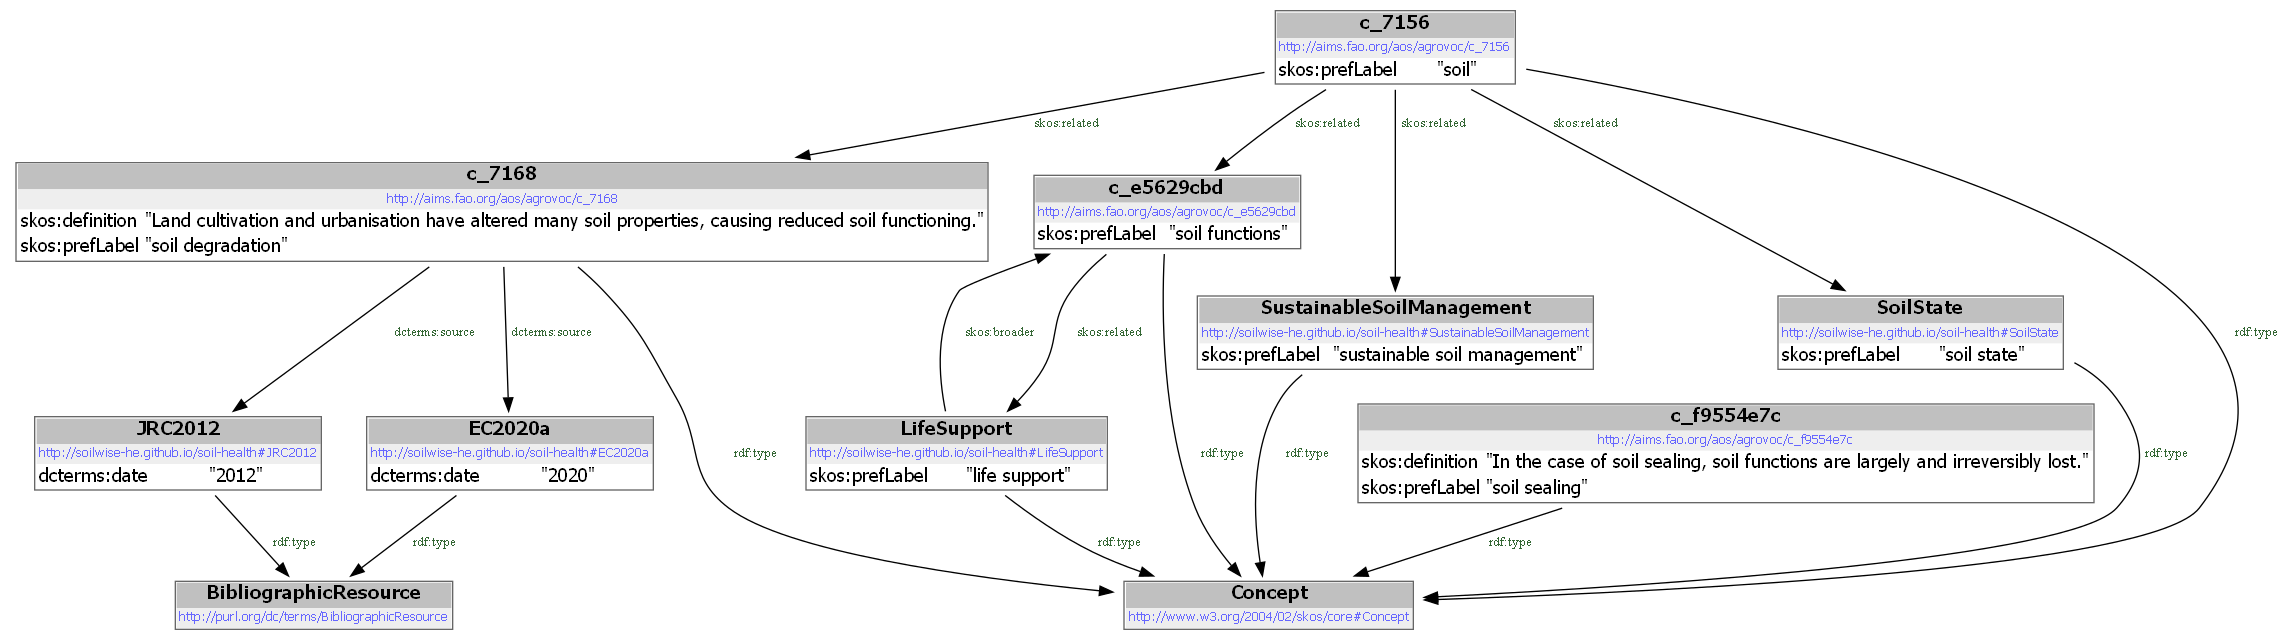

In [68]:
visualize(g_1)

#### RAG

### Evaluate different strategies

In [107]:
def calculate_metrics(generated_graph, ground_truth_graph):
    # Extract triples from graphs
    generated_triples = list(generated_graph)
    ground_truth_triples = list(ground_truth_graph)

    # Extract subjects, predicates, and objects from triples
    def extract_parts(triples):
        subjects, predicates, objects = zip(*triples)
        return list(subjects), list(predicates), list(objects)

    generated_subjects, generated_predicates, generated_objects = extract_parts(generated_triples)
    ground_subjects, ground_predicates, ground_objects = extract_parts(ground_truth_triples)

    # Convert lists to sets to compute unique matches
    generated_set = set(generated_triples)
    ground_truth_set = set(ground_truth_triples)

    # Triple-level metrics
    tp_triples = len(generated_set & ground_truth_set)
    fp_triples = len(generated_set - ground_truth_set)
    fn_triples = len(ground_truth_set - generated_set)
    triple_precision = tp_triples / (tp_triples + fp_triples) if (tp_triples + fp_triples) > 0 else 0.0
    triple_recall = tp_triples / (tp_triples + fn_triples) if (tp_triples + fn_triples) > 0 else 0.0
    triple_f1 = (2 * triple_precision * triple_recall) / (triple_precision + triple_recall) if (triple_precision + triple_recall) > 0 else 0.0

    # Subject-level metrics
    tp_subjects = len(set(generated_subjects) & set(ground_subjects))
    fp_subjects = len(set(generated_subjects) - set(ground_subjects))
    fn_subjects = len(set(ground_subjects) - set(generated_subjects))
    subject_precision = tp_subjects / (tp_subjects + fp_subjects) if (tp_subjects + fp_subjects) > 0 else 0.0
    subject_recall = tp_subjects / (tp_subjects + fn_subjects) if (tp_subjects + fn_subjects) > 0 else 0.0
    subject_f1 = (2 * subject_precision * subject_recall) / (subject_precision + subject_recall) if (subject_precision + subject_recall) > 0 else 0.0

    # Predicate-level metrics
    tp_predicates = len(set(generated_predicates) & set(ground_predicates))
    fp_predicates = len(set(generated_predicates) - set(ground_predicates))
    fn_predicates = len(set(ground_predicates) - set(generated_predicates))
    predicate_precision = tp_predicates / (tp_predicates + fp_predicates) if (tp_predicates + fp_predicates) > 0 else 0.0
    predicate_recall = tp_predicates / (tp_predicates + fn_predicates) if (tp_predicates + fn_predicates) > 0 else 0.0
    predicate_f1 = (2 * predicate_precision * predicate_recall) / (predicate_precision + predicate_recall) if (predicate_precision + predicate_recall) > 0 else 0.0

    # Object-level metrics
    tp_objects = len(set(generated_objects) & set(ground_objects))
    fp_objects = len(set(generated_objects) - set(ground_objects))
    fn_objects = len(set(ground_objects) - set(generated_objects))
    object_precision = tp_objects / (tp_objects + fp_objects) if (tp_objects + fp_objects) > 0 else 0.0
    object_recall = tp_objects / (tp_objects + fn_objects) if (tp_objects + fn_objects) > 0 else 0.0
    object_f1 = (2 * object_precision * object_recall) / (object_precision + object_recall) if (object_precision + object_recall) > 0 else 0.0

    # Overall subject, predicate, and object-level metrics
    overall_precision = (subject_precision + predicate_precision + object_precision) / 3
    overall_recall = (subject_recall + predicate_recall + object_recall) / 3
    overall_f1 = (subject_f1 + predicate_f1 + object_f1) / 3

    # Print metrics
    print("Triple-Level Precision: {:.4f}".format(triple_precision))
    print("Triple-Level Recall: {:.4f}".format(triple_recall))
    print("Triple-Level F1-Score: {:.4f}\n".format(triple_f1))

    print("Subject Precision: {:.4f}".format(subject_precision))
    print("Subject Recall: {:.4f}".format(subject_recall))
    print("Subject F1-Score: {:.4f}\n".format(subject_f1))

    print("Predicate Precision: {:.4f}".format(predicate_precision))
    print("Predicate Recall: {:.4f}".format(predicate_recall))
    print("Predicate F1-Score: {:.4f}\n".format(predicate_f1))

    print("Object Precision: {:.4f}".format(object_precision))
    print("Object Recall: {:.4f}".format(object_recall))
    print("Object F1-Score: {:.4f}\n".format(object_f1))

    print("Overall Precision: {:.4f}".format(overall_precision))
    print("Overall Recall: {:.4f}".format(overall_recall))
    print("Overall F1-Score: {:.4f}".format(overall_f1))

In [104]:
#Results of zero-shot
calculate_metrics(g_0, load_graph(dataset[1]['rdf_graph_turtle']))

Triple-Level Precision: 0.3333
Triple-Level Recall: 0.2727
Triple-Level F1-Score: 0.3000

Subject Precision: 0.5000
Subject Recall: 0.5000
Subject F1-Score: 0.5000

Predicate Precision: 0.5000
Predicate Recall: 0.3750
Predicate F1-Score: 0.4286

Object Precision: 0.4091
Object Recall: 0.3333
Object F1-Score: 0.3673

Overall Precision: 0.4697
Overall Recall: 0.4028
Overall F1-Score: 0.4320


In [105]:
#Results of prompt engineering
calculate_metrics(g_p, load_graph(dataset[1]['rdf_graph_turtle']))

Triple-Level Precision: 0.5000
Triple-Level Recall: 0.4545
Triple-Level F1-Score: 0.4762

Subject Precision: 0.7143
Subject Recall: 0.7143
Subject F1-Score: 0.7143

Predicate Precision: 0.8333
Predicate Recall: 0.6250
Predicate F1-Score: 0.7143

Object Precision: 0.6957
Object Recall: 0.5926
Object F1-Score: 0.6400

Overall Precision: 0.7478
Overall Recall: 0.6440
Overall F1-Score: 0.6895


In [106]:
#Results of one-shot
calculate_metrics(g_1, load_graph(dataset[1]['rdf_graph_turtle']))

Triple-Level Precision: 0.4286
Triple-Level Recall: 0.2727
Triple-Level F1-Score: 0.3333

Subject Precision: 0.6667
Subject Recall: 0.4286
Subject F1-Score: 0.5217

Predicate Precision: 0.7143
Predicate Recall: 0.6250
Predicate F1-Score: 0.6667

Object Precision: 0.5500
Object Recall: 0.4074
Object F1-Score: 0.4681

Overall Precision: 0.6437
Overall Recall: 0.4870
Overall F1-Score: 0.5522


### Post-process the knowledge graph

In [136]:
def parse_turtle(turtle_string):
    g = Graph()
    g.parse(data=turtle_string, format='turtle')
    return g

def merge_graphs(json_data):
    merged_graph = Graph()
    
    for item in json_data['dataset']:
        turtle_string = item['rdf_graph_turtle']
        graph = parse_turtle(turtle_string)
        merged_graph += graph
    
    return merged_graph

def remove_duplicates(graph):
    # Create a new graph to store unique triples
    unique_graph = Graph()
    
    # Iterate through all triples in the original graph
    for s, p, o in graph:
        # Check if the triple already exists in the unique graph
        if not (s, p, o) in unique_graph:
            unique_graph.add((s, p, o))
    
    return unique_graph

def main(file_path):
    merged_graph = merge_graphs(data)
    unique_graph = remove_duplicates(merged_graph)

    unique_graph.bind("agrontology", agrontology)
    unique_graph.bind("eli", eli)
    unique_graph.bind("qudt", qudt)
    unique_graph.bind("she", she)
    unique_graph.bind("country", country)

    # Serialize the final graph to Turtle format
    output_file = "soil_health_KG.ttl"
    unique_graph.serialize(destination=output_file, format="turtle")

    return unique_graph

if __name__ == "__main__":
    file_path = "text_RDF_gs.json"
    unique_graph = main(file_path)

In [163]:
# Link to AGROVOC vocabs
# Function to normalize British English to American English
def normalize_uk_to_us(label):
    for uk_spelling, us_spelling in uk_us:
        # Use regular expressions to replace only full words
        label = re.sub(rf'\b{uk_spelling}\b', us_spelling, label)
    return label

def concept2agrovoc(g):
    # Load the CSV file
    pref_label_map = {}
    alt_label_map = {}
    with open("ex_ontovocabs/agrovoc.csv", encoding="utf8") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            new_uri = row['concept']
            pref_label = row['prefLabel'].lower()
            alt_labels = row['altLabels'].split(';') if row['altLabels'] else []
            pref_label_map[pref_label] = new_uri
            for alt_label in alt_labels:
                alt_label = alt_label.strip().lower()  # Clean and normalize altLabel
                if alt_label:
                    alt_label_map[alt_label] = new_uri

    # Iterate over the graph and process matching prefLabel and altLabel
    for s, p, o in g:
        label = str(o).lower()
        normalized_label = normalize_uk_to_us(label)  # Apply normalization

        if p == SKOS.prefLabel and normalized_label in pref_label_map:
            # Add skos:exactMatch triples
            exact_match_uri = rdflib.URIRef(pref_label_map[normalized_label])
            g.add((s, SKOS.exactMatch, exact_match_uri))
        elif p == SKOS.prefLabel and normalized_label in alt_label_map:
            # Add skos:closeMatch triples
            close_match_uri = rdflib.URIRef(alt_label_map[normalized_label])
            g.add((s, SKOS.closeMatch, close_match_uri))

    g.bind("agrovoc", agrovoc)
    return g

g_0 = concept2agrovoc(g_0)
print(g_0.serialize(format="turtle"))

@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

she:ComplexBiomaterial a skos:Concept ;
    skos:prefLabel "complex biomaterial" .

she:Soil a skos:Concept ;
    dcterms:source she:YoungAndCrawford2004 ;
    she:includesMaterial she:Air,
        she:LivingOrganism,
        she:Mineral,
        she:OrganicCompound,
        she:Water ;
    she:naturallyVaries she:VariationInSpaceAndTime ;
    she:providesFunction she:EcosystemService,
        she:LifeSupportFunction ;
    skos:definition "Soil is the top terrestrial layer of the Earth; is composed of a mixture of mineral and organic compounds, water, air and living organisms; is one of the most complex biomaterials on earth; provides multiple functions that support the delivery of ecosystem services, including the life support function; varies naturally in both space and t

In [181]:
# Link to ISO11074
# Function to normalize British English to American English
def normalize_uk_to_us(label):
    for uk_spelling, us_spelling in uk_us:
        # Use regular expressions to replace only full words
        label = re.sub(rf'\b{uk_spelling}\b', us_spelling, label)
    return label

def concept2ISO(g):
    # Load the CSV file
    pref_label_map = {}
    alt_label_map = {}
    with open("ex_ontovocabs/ISO11074.csv", encoding="utf8") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            new_uri = row['id']
            pref_label = row['prefLabel'].lower()
            alt_labels = row['altLabel'].split(';') if row['altLabel'] else []
            pref_label_map[pref_label] = new_uri
            for alt_label in alt_labels:
                alt_label = alt_label.strip().lower()  # Clean and normalize altLabel
                if alt_label:
                    alt_label_map[alt_label] = new_uri

    # Iterate over the graph and process matching prefLabel and altLabel
    for s, p, o in g:
        label = str(o).lower()
        normalized_label = normalize_uk_to_us(label)  # Apply normalization

        if p == SKOS.prefLabel and normalized_label in pref_label_map:
            # Add skos:exactMatch triples
            exact_match_uri = rdflib.URIRef(pref_label_map[normalized_label])
            g.add((s, SKOS.exactMatch, exact_match_uri))
        elif p == SKOS.prefLabel and normalized_label in alt_label_map:
            # Add skos:closeMatch triples
            close_match_uri = rdflib.URIRef(alt_label_map[normalized_label])
            g.add((s, SKOS.closeMatch, close_match_uri))

    g.bind("iso11074", iso11074)
    return g

g_0 = concept2ISO(g_0)
print(g_0.serialize(format="turtle"))

@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix iso11074: <http://data.geoscience.earth/ncl/ISO11074/> .
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

she:DegradedSoils a skos:Concept ;
    she:harm she:Ecosystems ;
    skos:definition "Such soils are then degraded, which consequently harms ecosystems and their life support functions." ;
    skos:prefLabel "degraded soils" .

she:EC2020a a dcterms:BibliographicResource ;
    dcterms:source she:LandCultivation,
        she:Urbanisation .

she:HealthySoils a skos:Concept ;
    she:deliver she:EcosystemServices ;
    skos:prefLabel "healthy soils" .

she:JRC2012 a dcterms:BibliographicResource ;
    dcterms:source she:LandCultivation,
        she:Urbanisation .

she:SoilFunctions a skos:Concept ;
    skos:exactMatch iso11074:3.3.31 ;
    skos:prefLabel "soil functions" .

she:SoilSealing a skos:Concept ;
    skos:definition "In the case of soil sealing, soil funct

### Interlink to external databases: a Zenodo example

In [109]:
# Define the API endpoint URL
api_url = "https://zenodo.org/api/records"

# query for datasources with 'soil'
# get first 200 datasources
# loop through pages to retrieve next part of data
# only get sources with status published
# options: https://developers.zenodo.org/?python#list36

# list to gather all data through API requests
zenodo_data = []

# loop through pages to retreive next part of data
for i in range(1,11):
    print(f'loop num {i}')
    params = {'q': 'soil',
              'size':'20',
              'page':f'{i}',
              'status':'published',
              'sort':'bestmatch',
              'access_token': config['access_token_zenodo']}
    headers = {"Content-Type": "application/json"}

    # Make the API request
    response = requests.get(api_url,params = params, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()
        zenodo_data = zenodo_data + data['hits']['hits']
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
    
zenodo_data

loop num 1
loop num 2
loop num 3
loop num 4
loop num 5
loop num 6
loop num 7
loop num 8
loop num 9
loop num 10


[{'created': '2021-08-05T16:06:00.842433+00:00',
  'modified': '2021-08-06T01:48:27.870247+00:00',
  'id': 5159133,
  'conceptrecid': '5159132',
  'doi': '10.5281/zenodo.5159133',
  'conceptdoi': '10.5281/zenodo.5159132',
  'doi_url': 'https://doi.org/10.5281/zenodo.5159133',
  'metadata': {'title': 'Soil Survey of Scotland Staff (1970-1987). Soil maps of Scotland (partial coverage) at a scale of 1:25 000. Digital phase 8 release.',
   'doi': '10.5281/zenodo.5159133',
   'publication_date': '2021-08-04',
   'description': '<p>This is the digital dataset which was created by digitising the Soils of Scotland 1:25,000 Soil maps and the Soils of Scotland 1:25,000 Dyeline Masters. The Soils of Scotland 1:25,000 Soil maps were the source documents for the production of the Soils of Scotland 1:63,360 and 1:50,000 published map series. Where no 1:25,000 published maps exist 1:63,360 maps have been digitised for this data set, the field SOURCE_MAP describes the source of the data. The classific

In [110]:
# gather the id's in list to then extract data directly as dublincore representation
id_list = []
for i in range(0,len(zenodo_data)):
    id_list.append(zenodo_data[i]['id'])

In [111]:
# Convert HTML to plain text
class CleanHTML(HTMLParser):
    def reset(self) -> None:
        self.extracted_data = ""
        return super().reset()

    def remove_tags(self, html_data: str) -> str:
        """
        Args:
            html_data (str): HTML data which might contain tags.

        Returns:
            str: Data without any HTML tags. Forces feeding of any buffered data.
        """
        self.reset()
        self.feed(html_data)
        self.close()
        return self.extracted_data

    def handle_data(self, data: str) -> None:
        """
        Args:
            data (str): Html data extracted from tags to be processed.
        """
        self.extracted_data += data

p = CleanHTML()

In [ ]:
# Extract DublinCore standardized metadata and generate json with all data
zenodo_dc_data = {}
for i in range(len(id_list)):

    # Define the API endpoint URL
    api_url = f"https://zenodo.org/records/{id_list[i]}/export/dublincore"
    params = {'access_token': config['access_token_zenodo']}
    headers = {"Content-Type": "application/json"}

    # Make the API request
    response = requests.get(api_url, params = params, headers=headers, timeout=None)

    # Check if the request was successful
    if response.status_code == 200:
        try:
            # Parse the XML response
            root = ET.fromstring(response.content)

            # Define expected tags with namespace
            expected_tags = {
                "{http://purl.org/dc/elements/1.1/}creator": None,      # Initialize as None
                "{http://purl.org/dc/elements/1.1/}subject": None,      # Initialize as None
                "{http://purl.org/dc/elements/1.1/}date": None,         # Initialize as None
                "{http://purl.org/dc/elements/1.1/}title": None,        # Initialize as None
                "{http://purl.org/dc/elements/1.1/}description": None,   # Initialize as None
                "{http://purl.org/dc/elements/1.1/}identifier": None,    # Initialize as None
                "{http://purl.org/dc/elements/1.1/}language": None    # Initialize as None
            }

            # Create a dictionary for JSON conversion
            json_dict = {}

            # Check if the root has child elements
            if root:
                for child in root:
                    # Get full tag name, preserving namespace
                    tag = child.tag
                    text = p.remove_tags(unescape(child.text))  # Convert HTML entities to normal text

                    if tag in expected_tags:
                        if "creator" in tag or "subject" in tag:
                            if "creator" in tag:
                                if json_dict.get(tag) is None:
                                    json_dict[tag] = [text]
                                else:
                                    json_dict[tag].append(text)
                            elif "subject" in tag:
                                # Split subjects and strip spaces                              
                                subjects = [subj.strip() for subj in re.split(r'[;,]', text)]
                                if json_dict.get(tag) is None:                                  
                                    json_dict[tag] = subjects
                                else:
                                    json_dict[tag].extend(subjects)
                        else:
                            if json_dict.get(tag) is None:
                                json_dict[tag] = text  # Directly store as a string for date, title, description and identifier

                # Ensure all expected tags are included in the json_dict
                for tag, value in expected_tags.items():
                    if tag not in json_dict:
                        json_dict[tag] = value

                output_dict = {}
                # Adjusting the output to match the "dc:" prefix requirement
                for key, value in json_dict.items():
                    adjusted_key = key.split('}')[-1]  # Remove namespace URI
                    output_dict["dc:" + adjusted_key] = value

                zenodo_dict={
                    i:output_dict
                }
                
                #add to general json
                zenodo_dc_data.update(zenodo_dict)
            
            else:
                print("No repositories found in the response.")
        except ET.ParseError:
            print("Error: Unable to parse XML content.")
    else:
        # Print an error message if the request was not successful
        print(f"Error: Unable to fetch data. Status code: {response.status_code}")
        print(response.text)

In [133]:
# Convert metadata to RDF statements
# Dictionary of metadata entries, indexed by a unique key
metadata_entries = zenodo_dc_data

# Fill in all the missing keywords under named graph "augmented"
# Create a ConjunctiveGraph to store quads
g_zenodo_extend = ConjunctiveGraph()

# Define named graphs
metadata_graph = URIRef("http://soilwise-he.github.io/soil-health#metadata")
generated_graph = URIRef("http://soilwise-he.github.io/soil-health#augmented")

# keywords generation
def generate_subjects(text):
    # Placeholder function to simulate generating subjects based on the title
    kw_model = KeyBERT()
    seed_keywords = ["soil"]

    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words=None, seed_keywords=seed_keywords, use_mmr=True, diversity=0.5)
    keywords = [item[0] for item in keywords if item[1] > 0.5]
    
    return keywords

# Loop through each metadata entry
for entry_id, metadata in metadata_entries.items():
    if metadata['dc:language'] is None or metadata['dc:language'] == 'eng': 
        # Define the URI for the resource using its identifier
        resource_uri = URIRef(metadata['dc:identifier'])

        # Define the resource as a BibliographicResource
        g_zenodo_extend.add((resource_uri, RDF.type, DCTERMS.BibliographicResource, metadata_graph))
    
        # Add the title, date, and identifier
        g_zenodo_extend.add((resource_uri, DCTERMS.title, Literal(metadata['dc:title']), metadata_graph))
        g_zenodo_extend.add((resource_uri, DCTERMS.date, Literal(metadata['dc:date']), metadata_graph))
        g_zenodo_extend.add((resource_uri, DCTERMS.identifier, URIRef(metadata['dc:identifier']), metadata_graph))

        # Add creators, which can have multiple values
        for creator in metadata['dc:creator']:
            g_zenodo_extend.add((resource_uri, DCTERMS.creator, Literal(creator), metadata_graph))
    
        # Check if subjects are provided, otherwise generate them
        if metadata['dc:subject'] is None:
            generated_subjects = generate_subjects(f"{metadata['dc:title']}. {metadata['dc:description']}")
            for subject in generated_subjects:
                g_zenodo_extend.add((resource_uri, DCTERMS.subject, Literal(subject), generated_graph))
        else:
            for subject in metadata['dc:subject']:
                g_zenodo_extend.add((resource_uri, DCTERMS.subject, Literal(subject.strip()), metadata_graph))

# Output the graph in Turtle format
g_zenodo_extend.bind("she", she)

print(g_zenodo_extend.serialize(format="trig"))

@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <http://soilwise-he.github.io/soil-health#> .

she:augmented {
    <https://doi.org/10.5061/dryad.1g1jwstx3> dcterms:subject "grazing activity",
            "nitrogen soil" .

    <https://doi.org/10.5061/dryad.2280gb5rk> dcterms:subject "elevation soil",
            "fungal diversity" .

    <https://doi.org/10.5061/dryad.7d14j> dcterms:subject "soil respiration",
            "soil temperature" .

    <https://doi.org/10.5061/dryad.8cz8w9gpg> dcterms:subject "soil microbial" .

    <https://doi.org/10.5061/dryad.m37pvmczk> dcterms:subject "rhizocompartments soil",
            "soil microbial" .

    <https://doi.org/10.5061/dryad.p0jn1> dcterms:subject "ecosystems soil" .

    <https://doi.org/10.5061/dryad.p8cz8w9qv> dcterms:subject "archaea declined",
            "forest soil",
            "soil microbial" .

    <https://doi.org/10.5061/dryad.w3r2280nq> dcterms:subject "annual soil",
            "global soil",
            

In [134]:
# Interlink metadata quads with soil health knowledge graph
# Function to link concepts
def link_concepts(graph, concept_graph):
    # Extract all concept URIs and labels
    labels = {}
    for c in concept_graph.subjects(RDF.type, SKOS.Concept):
        pref_label = concept_graph.value(c, SKOS.prefLabel)
        labels[c] = [pref_label.lower() if pref_label else ""]

    for s, p, o, g in graph.quads((None, None, None, None)):
        subject_label = o.lower()
        for c, label_list in labels.items():
            if subject_label in label_list:
                graph.remove((s, p, o, g))
                graph.add((s, p, c, g))  # Preserve original predicate
                concept_graph.add((c, DCTERMS.source, s))

# Link concepts between metadata and concept graphs
link_concepts(g_zenodo_extend, unique_graph)

# Serialize the graphs to check the output
print("Concept Graph:")
print(unique_graph.serialize(format='turtle'))

Concept Graph:
@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix country: <http://publications.europa.eu/resource/authority/country/> .
@prefix dcmitype: <http://purl.org/dc/dcmitype/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix eli: <http://data.europa.eu/eli/ontology#> .
@prefix glosis_lh: <http://w3id.org/glosis/model/layerhorizon/> .
@prefix glosis_sp: <http://w3id.org/glosis/model/siteplot/> .
@prefix prov: <http://www.w3.org/ns/prov#> .
@prefix qudt: <http://qudt.org/schema/qudt/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix sosa: <http://www.w3.org/ns/sosa/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

agrovoc:c_2482 a skos:Concept ;
    agrontology:isAffectedBy agrovoc:c_7168 ;
    skos:prefLabel "ecosystems" .

agrovoc:c_25304 a skos:Concept ;
    ag

In [135]:
g_zenodo_extend.bind("agrovoc", agrovoc)
g_zenodo_extend.bind("she", she)

print("Metadata Graph:")
print(g_zenodo_extend.serialize(format='trig'))

Metadata Graph:
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix she: <http://soilwise-he.github.io/soil-health#> .

she:augmented {
    <https://doi.org/10.5061/dryad.1g1jwstx3> dcterms:subject "grazing activity",
            "nitrogen soil" .

    <https://doi.org/10.5061/dryad.2280gb5rk> dcterms:subject "elevation soil",
            "fungal diversity" .

    <https://doi.org/10.5061/dryad.7d14j> dcterms:subject "soil respiration",
            "soil temperature" .

    <https://doi.org/10.5061/dryad.8cz8w9gpg> dcterms:subject "soil microbial" .

    <https://doi.org/10.5061/dryad.m37pvmczk> dcterms:subject "rhizocompartments soil",
            "soil microbial" .

    <https://doi.org/10.5061/dryad.p0jn1> dcterms:subject "ecosystems soil" .

    <https://doi.org/10.5061/dryad.p8cz8w9qv> dcterms:subject "archaea declined",
            "forest soil",
            "soil microbial" .

    <https://doi.org/10.5061/dryad.w3r2280nq> 

In [136]:
concept_graph_extended = ConjunctiveGraph()

for triple in unique_graph:
    concept_graph_extended.add(triple)

for quad in g_zenodo_extend.quads((None, None, None, None)):
    concept_graph_extended.add(quad)

concept_graph_extended.bind("agrovoc", agrovoc)
concept_graph_extended.bind("she", she)
concept_graph_extended.bind("glosis_lh", glosis_lh)
concept_graph_extended.bind("agrontology", agrontology)
concept_graph_extended.bind("glosis_sp", glosis_sp)
concept_graph_extended.bind("eli", eli)
concept_graph_extended.bind("qudt", qudt)
concept_graph_extended.bind("country", country)

print(concept_graph_extended.serialize(format='trig'))
# Save the graph to a file
concept_graph_extended.serialize(destination="example_SWR.trig", format="trig")

@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix country: <http://publications.europa.eu/resource/authority/country/> .
@prefix dcmitype: <http://purl.org/dc/dcmitype/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix eli: <http://data.europa.eu/eli/ontology#> .
@prefix glosis_lh: <http://w3id.org/glosis/model/layerhorizon/> .
@prefix glosis_sp: <http://w3id.org/glosis/model/siteplot/> .
@prefix prov: <http://www.w3.org/ns/prov#> .
@prefix qudt: <http://qudt.org/schema/qudt/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix she: <http://soilwise-he.github.io/soil-health#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix sosa: <http://www.w3.org/ns/sosa/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

{
    agrovoc:c_2482 a skos:Concept ;
        agrontology:isAffectedBy agrovoc:c_7168 ;
        skos:prefLabel "ecosystems" .

    agrovoc:c_25304 a skos:Concept ;
   

<Graph identifier=Na956a607228c4fa79f84c97ebcc34132 (<class 'rdflib.graph.ConjunctiveGraph'>)>

### Validate the knowledge graph by question answering (with NLQ)

In [138]:
graph = RdfGraph(
    source_file="soil_health_KG.ttl",
    serialization="ttl",
)

In [139]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)
chain = GraphSparqlQAChain.from_llm(llm=llm, graph=graph, return_sparql_query=True, verbose=True)

In [140]:
print(graph.get_schema)

In the following, each IRI is followed by the local name and optionally its description in parentheses. 
The RDF graph supports the following node types:
<http://www.w3.org/2004/02/skos/core#Concept> (Concept, None), <http://qudt.org/schema/qudt/QuantityValue> (QuantityValue, None), <http://purl.org/dc/terms/BibliographicResource> (BibliographicResource, None), <http://purl.org/dc/terms/Policy> (Policy, None), <http://qudt.org/schema/qudt/SystemOfQuantityKinds> (SystemOfQuantityKinds, None), <http://semanticscience.org/resource/SIO_000368> (SIO_000368, None), <http://qudt.org/schema/qudt/QuantityKind> (QuantityKind, None), <http://purl.org/dc/terms/Standard> (Standard, None), <http://qudt.org/schema/qudt/Unit> (Unit, None), <http://www.w3.org/ns/sosa/Procedure> (Procedure, None), <http://data.europa.eu/eli/ontology#LegalResource> (LegalResource, None), <http://qudt.org/vocab/unit/PercentageUnit> (PercentageUnit, None), <http://purl.org/dc/dcmitype/Image> (Image, None), <http://purl.org

In [74]:
result = chain.invoke("""
    Give me all the references related to the concept "soil".

    Please only generate the pure SPARQL query without any quote and '```';
    Note that the references is labeled by "dcterms:source", thank you!
""")

print(f"Final answer: {result['result']}")



> Entering new GraphSparqlQAChain chain...
Identified intent:
SELECT
Generated SPARQL:
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT ?reference
WHERE {
    ?concept skos:prefLabel "soil" .
    ?concept dcterms:source ?reference .
}
Full Context:
[(rdflib.term.URIRef('http://soilwise-he.github.io/soil-health#YoungCrawford2004'),), (rdflib.term.URIRef('https://doi.org/10.5281/zenodo.1131349'),), (rdflib.term.URIRef('https://doi.org/10.5281/zenodo.13757029'),), (rdflib.term.URIRef('https://doi.org/10.5281/zenodo.5159133'),), (rdflib.term.URIRef('https://doi.org/10.5281/zenodo.6921102'),), (rdflib.term.URIRef('https://doi.org/10.5281/zenodo.7142458'),), (rdflib.term.URIRef('https://doi.org/10.5281/zenodo.7656722'),), (rdflib.term.URIRef('https://doi.org/10.5281/zenodo.7709206'),)]

> Finished chain.
Final answer: SELECT ?reference
WHERE {
    ?reference dcterms:source ?source .
    FILTER(CONTAINS(LCASE(STR(?source)), "soil"))
}


In [72]:
query = result['sparql_query']

# Execute the query
for row in graph.query(query):
    print(f"Soil health: {row.soilHealthNote}\nSoil quality: {row.soilQualityNote}")

In [76]:
with open('benchmarks/q_SPARQL_a.json', 'r') as f:
    qa = json.load(f)

qa_pair = qa['qa_pairs'][0]
query = qa_pair['sparql_query']

query = """PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX she: <http://soilwise-he.github.io/soil-health#>
PREFIX agrovoc: <http://aims.fao.org/aos/agrovoc/>

SELECT ?factorLabel ?factorValue ?factorDefinition ?recommendation
WHERE {
  ?conversionFactor a qudt:QuantityValue ;
                    qudt:numericValue ?factorValue ;
                    rdfs:label ?factorLabel ;
                    skos:definition ?factorDefinition ;
                    skos:scopeNote ?recommendation .
}
ORDER BY ?conversionFactor"""

for row in graph.query(query):
    print(f"{row.factorLabel}: {row.factorValue}, {row.factorDefinition} {row.recommendation}")

conversion factor 1.724: 1.724, A factor historically used to convert Soil Organic Carbon (SOC) to Soil Organic Matter (SOM) based on the assumption that organic matter is 58% carbon. To avoid uncertainties related to conversion factors, it is recommended to use Soil Organic Carbon (SOC) as measured without converting to Soil Organic Matter (SOM).
conversion factor 2.0: 2.0, A more accurate factor for converting Soil Organic Carbon (SOC) to Soil Organic Matter (SOM), especially for soil layers rich in organic matter. To avoid uncertainties related to conversion factors, it is recommended to use Soil Organic Carbon (SOC) as measured without converting to Soil Organic Matter (SOM).
